# sivtempfit generative model testing
Ruffin Evans
2016-04-18

This notebook loads in and performs some simple tests on the generative model that will be used to fit the spectra data in this package.

See model-development.ipynb for model development and explanation.

## Standard Imports

In [8]:
# makes plots display inline in notebook interface:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import emcee
import pandas as pd
import seaborn as sns
import scipy.stats as stats # Use for KDE in the end
import scipy.optimize as opt # Use for minimizing KDE
import scipy as sp
sns.set_style("whitegrid")

### Import package modules

In [9]:
import sivtempfit.dataprocessing as dp
import sivtempfit.io as io
import sivtempfit.model as model
from sivtempfit.model import *

### Simple tests for model

Before we do the full monte carlo treatment, let's test that our likelihood function behaves in a reasonable way on test data. The simplest way to do this is to just use data generated from our model and see if our likelihood function is peaked where it should be. Later, I will run these tests with emcee and the unit testing framework, but for now let's just check the basics.

#### Setup

Load simple test case, with data from the function plus gaussian noise of mean 1 and standard deviation 0.5.

In [10]:
simulated_spectrum = io.load_Spectrum("sivtempfit/exampledata/simulated_spectrum.json")
print(simulated_spectrum.metadata['Description'])

Data generated from two_peak_model with the following command:
two_peak_model(xrange, 500, 10, -30, 70, 20, 0.1, 1) + np.random.normal(1,0.5,10000)


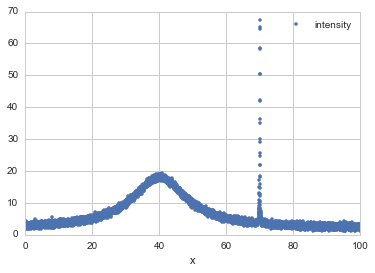

In [11]:
simulated_spectrum.data.plot('x', 'intensity', style = '.')

##### Test sensitivity to background parameters

These should both be peaked at 1:

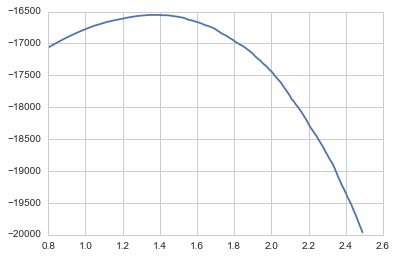

In [13]:
test_amp_list = np.arange(0.8,2.5,0.01)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, 20, 0.1, 1, x, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

I don't know why it is peaked at 1.4.

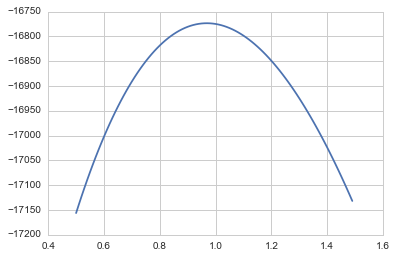

In [15]:
test_amp_list = np.arange(0.5,1.5,0.01)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, 20, 0.1, x, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

We can also look at the best guess on the standard deviation, which should be 0.5:

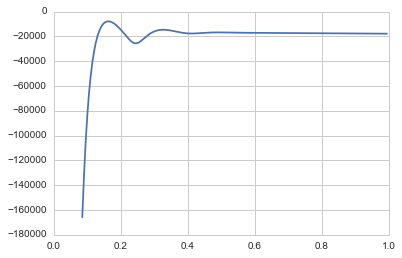

In [16]:
test_amp_list = np.arange(0.065,1,0.005)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, 20, 0.1, 1, 1, x) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

These oscillations are very strange! I think they are a numerical artifact resulting from the fact that the standard deviation also determines the range over which to do the convolution. We can make this range fixed and large.

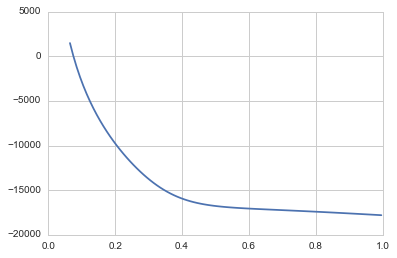

In [18]:
test_amp_list = np.arange(0.065,1,0.01)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, 20, 0.1, 1, 1, x, 50/x) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

In this case, the likelihood diverges for small sigma.

# TODO: Look at Gaussian contribution and troubleshoot. Something wrong, perhaps with convolution.

##### Test sensitivity to amplitudes

First, test to make sure the likelihood has a sharp peak when the amplitudes of the two peaks in the model are properly selected.

This graph should be peaked around 500:

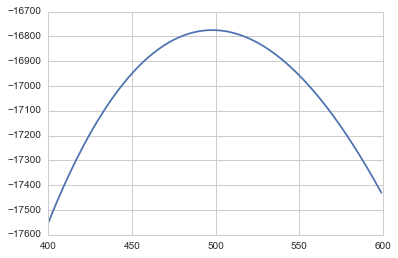

In [19]:
test_amp_list = np.arange(400,600,1)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, x, 10, 0, 0, -30, 70, 20, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

This should be peaked around 10, the amplitude of the other peak.

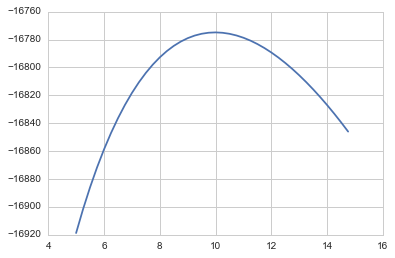

In [20]:
test_amp_list = np.arange(5,15,0.25)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, x, 0, 0, -30, 70, 20, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

##### Test sensitivity to center positions

These two graphs should be peaked around -30 and 70, respectively.

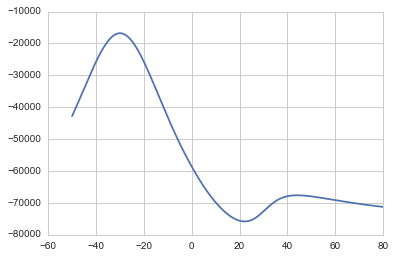

In [21]:
test_amp_list = np.arange(-50,80,0.1)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, x, 70, 20, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

-61883.3072258
-72863.8644057


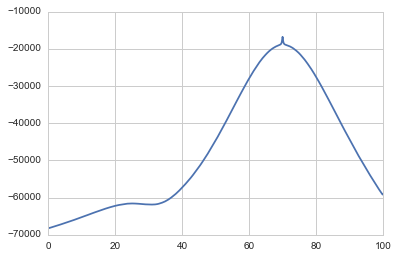

In [23]:
test_amp_list = np.arange(0,100,0.05)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, x, 20, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)
print(two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 30, 20, 0.1, 1, 1, 0.5))
print(two_peak_log_likelihood_Spectrum(simulated_spectrum, 5, 10, 0, 0, -30, 70, 20, 0.1, 1, 1, 0.5))

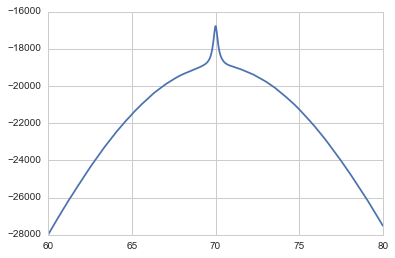

In [24]:
test_amp_list = np.arange(60,80,0.01)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, x, 20, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

Look at how sharp that peak is. This is monotonic, so there shouldn't be any problems in terms of exploring the peak, but if the step size is too small it could be bad. Need to pay special attention to this parameter.

##### Test widths

The following two graphs should be peaked at 20 and 0.1, respectively.

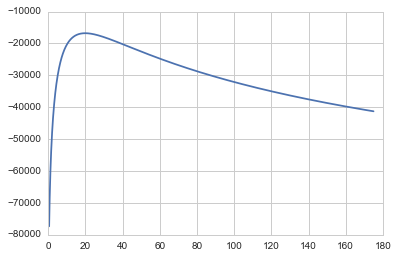

In [25]:
test_amp_list = np.arange(0,175,0.1)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, x, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

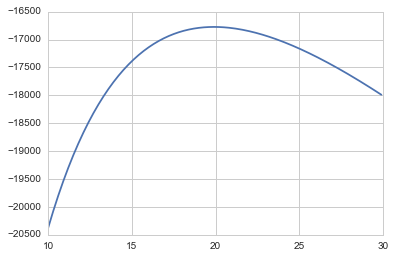

In [26]:
test_amp_list = np.arange(10,30,0.1)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, x, 0.1, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

The other peak width looks OK. It is peaked around 0.1 as expected:

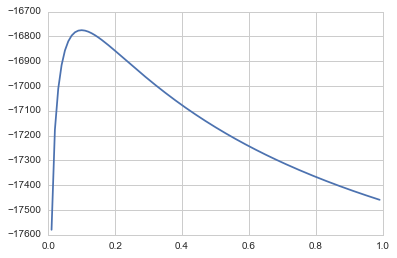

In [27]:
test_amp_list = np.arange(-1,1,0.01)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, 20, x, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

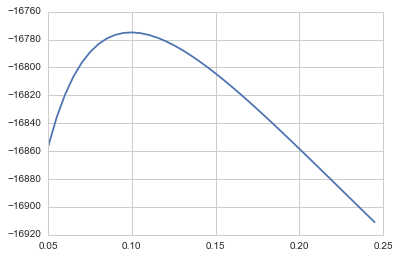

In [28]:
test_amp_list = np.arange(0.05,0.25,0.005)
test_ll = [two_peak_log_likelihood_Spectrum(simulated_spectrum, 500, 10, 0, 0, -30, 70, 20, x, 1, 1, 0.5) for x in test_amp_list]
plt.plot(test_amp_list, test_ll)

In [33]:
test_amp_list[test_ll.index(max(test_ll))]

0.099999999999999978